In [1]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
from array import array
import collections

inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'xsec_momentum_fit_res_both/' 
output_filedir = outputdir
input_filedir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
lib_function_dir = '/home/tmettler/Desktop/uBoone/do_plots/'

plot_systematic = 0

# helper functions
globale = imp.load_source('globale',lib_function_dir+'globale.py')
NuCC = imp.load_source('NuCC_function',lib_function_dir+'NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function',lib_function_dir+'NuCCWeight_function.py')

Welcome to JupyROOT 6.18/04


In [2]:
#!jupyter nbconvert --to script numuCCana_xsec_weighted.ipynb

In [3]:
# initialte ROOT default canvas
ROOT.gROOT.SetBatch(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# Cross section for single differnetial in Momentum (no sys)

In [4]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
outputdir_png, outputdir_root,outputdir_pdf = NuCC.prepareOutput2(outputdir)
try:
    os.stat(output_filedir)
except:
    os.mkdir(output_filedir)
RootFile = ROOT.TFile(output_filedir+"xsec_momentum_fit.root","RECREATE");

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
#filename_overlay = 'NuCCana_overlay_V26_weight.root'
filename_overlay = 'NuCCana_overlay_V26_mar18.root'
filename_data = 'NuCCana_data_V25.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [5]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =    7.644e+18  # best with tor875
data_trigger = 1838700.0 #2220362.0 #1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	1012051
Data: Number of Entries:	28005
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		7.644e+18
Ext:		0
Overlay:	1.26811760704e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0967862715198
Overlay:	0.0060278320856
Dirt:		0.0611423668132


In [6]:
if 1:
    filename_overlay = filename_overlay+'out4_noflux.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out4.root'
    filename_ext = filename_ext+'out4.root'
    filename_dirt = filename_dirt+'out4.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	1013969
Data: Number of Entries:	28004
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40800



In [7]:
##### flux and number of tragets parameters###
flux = 1.16859e11/1.592e20 # flux per POT per cm2
print flux
flux = 7.3789785277e-10
print flux
roh_data = 1.3836 #data denisity g/cm3
roh_MC = 1.3954 # MC denisity g/cm3
mol = 39.95 # g for argon
N_A = 6.022140857e23 # molec/mol avogadro zahl
N_nucleons = 40.0
V_fid = ((254.8-10)-(-1.55+10))*((117.47-10)-(-115.53+10))*((1036.9-50)-(-0.1+10))
print 'Fiducial Volume: ', V_fid
##############################################

beam_flux = flux * pot_data
print 'Beam flux = {:.5e}'.format(beam_flux),' /cm2'
N_tot = roh_data*N_A*N_nucleons*V_fid/mol
print 'Number of target nuclei= {:.5e}'.format(N_tot),' /cm3'

7.34038944724e-10
7.3789785277e-10
Fiducial Volume:  49184671.35
Beam flux = 5.64049e+09  /cm2
Number of target nuclei= 4.10331e+31  /cm3


In [8]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')

energy_cut = ' && MCle_Energy>0.15'

numu_signal = numu_signal+energy_cut
numu_true = numu_true+energy_cut
numu_nomu = numu_nomu+energy_cut
numu_lowpur = numu_lowpur+energy_cut
numu_nc = numu_nc+energy_cut
numu_ov = numu_ov+energy_cut
numu_other = numu_other+energy_cut

num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = {'numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other'}

In [9]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [10]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root,outputdir_pdf)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [11]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [12]:
'''track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'
'''
track_start_border_x = '(TrackStart_x_sce <(-1.55+5) || TrackStart_x_sce > (254.8-5))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+5) || TrackEnd_x_sce > (254.8-5))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+5) || TrackStart_y_sce > (117.47-5))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+5) || TrackEnd_y_sce > (117.47-5))'
track_start_border_z = '(TrackStart_z_sce <(0.1+5) || TrackStart_z_sce > (1036.9-5))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+5) || TrackEnd_z_sce > (1039.9-5))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-4)<0.9 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-4)<0.9 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.95)<0.9 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time+(crt_trig_corr_med)/1000-3.57+3.195-3.95)<0.9 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-3.95)<0.9 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)

weight_name = 'EventWeight*TunedCentralValue_Genie'


In [13]:
def draw_adding():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/25.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()

    pot_latex = ROOT.TLatex(.10, .92,'Accumulated POT: '+str(pot_data)) 
    pot_latex.SetTextFont(62);
    pot_latex.SetTextColor(ROOT.kGray+2);
    pot_latex.SetNDC();
    pot_latex.SetTextSize(1/25.);
    pot_latex.SetTextAlign(10) #;//left adjusted
    pot_latex.Draw();
    
    return prelim, pot_latex

def draw_sim():
    prelim = ROOT.TLatex(0.9,0.93, "MicroBooNE Simulation Preliminary");
    prelim.SetTextFont(62);
    prelim.SetTextColor(ROOT.kGray+2);
    prelim.SetNDC();
    prelim.SetTextSize(1/20.);
    prelim.SetTextAlign(32);
    #prelim.SetTextSize(0.04631579);
    prelim.Draw()
    
    return prelim

In [14]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.05)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [15]:
from array import array
mom_bins = [ 0.0, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
binnum = len(mom_bins) - 1
h_xsec_mom = ROOT.TH1F('h_xsec_mom','h_xsec_mom',binnum,array('f',mom_bins))

In [16]:
# calculate total flux integrated cross section:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1' #\
                #&& MCle_Energy>0 && MCle_Energy<2.5 && TrackMomMCS_mom>0 && TrackMomMCS_mom<2.5'


In [17]:
n = 200
start = 0.15
end = 2.5
mom_bins2 = np.zeros((n+1))
for i in range(n+1):
    mom_bins2[i] = (end-start)/n*i+start
binnum2 = len(mom_bins2) - 1
print mom_bins2

#mom_bins2 = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]
#binnum2 = len(mom_bins) - 1

[0.15    0.16175 0.1735  0.18525 0.197   0.20875 0.2205  0.23225 0.244
 0.25575 0.2675  0.27925 0.291   0.30275 0.3145  0.32625 0.338   0.34975
 0.3615  0.37325 0.385   0.39675 0.4085  0.42025 0.432   0.44375 0.4555
 0.46725 0.479   0.49075 0.5025  0.51425 0.526   0.53775 0.5495  0.56125
 0.573   0.58475 0.5965  0.60825 0.62    0.63175 0.6435  0.65525 0.667
 0.67875 0.6905  0.70225 0.714   0.72575 0.7375  0.74925 0.761   0.77275
 0.7845  0.79625 0.808   0.81975 0.8315  0.84325 0.855   0.86675 0.8785
 0.89025 0.902   0.91375 0.9255  0.93725 0.949   0.96075 0.9725  0.98425
 0.996   1.00775 1.0195  1.03125 1.043   1.05475 1.0665  1.07825 1.09
 1.10175 1.1135  1.12525 1.137   1.14875 1.1605  1.17225 1.184   1.19575
 1.2075  1.21925 1.231   1.24275 1.2545  1.26625 1.278   1.28975 1.3015
 1.31325 1.325   1.33675 1.3485  1.36025 1.372   1.38375 1.3955  1.40725
 1.419   1.43075 1.4425  1.45425 1.466   1.47775 1.4895  1.50125 1.513
 1.52475 1.5365  1.54825 1.56    1.57175 1.5835  1.59525 1.607 

In [18]:
h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('MCle_Energy>>h_true',weight_name+'*('+cut+' && numu_signal)')
#globale.overlay_out.Draw('MCle_Energy>>h_true',weight_name+'*(1 && numu_true)')
h_true.Scale(scale[overlay])
h_true.Write('mom_truth_sig')

h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
#globale.overlay_out.Draw('MCle_Energy>>h_true',weight_name+'*('+cut+' && numu_signal)')
globale.overlay_out.Draw('MCle_Energy>>h_true',weight_name+'*(1 && numu_true)')
h_true.Scale(scale[overlay])
h_true.Write('mom_truth')
#h_true.Draw()
#c1.Draw()

430

Warning in <TFile::Append>: Replacing existing TH1: h_true (Potential memory leak).


In [19]:
h_temp = []
h_temp_r = []
for i in range(binnum):
    print i
    h_temp.append(ROOT.TH1F('h_temp['+str(i)+']','Template for ture bin '+str(i),binnum2,array('f',mom_bins2)))
    h_temp_r.append(ROOT.TH1F('h_temp_r['+str(i)+']','h_temp_r['+str(i)+']',binnum2,array('f',mom_bins2)))
    bincut = 'MCle_Energy < '+str(mom_bins[i+1])+' && MCle_Energy > '+str(mom_bins[i])
    print bincut
    globale.overlay_out.Draw('TrackMomMCS_mom>>h_temp['+str(i)+']',weight_name+'*('+cut+'&&'+bincut+' && numu_signal && track_end_uncontained)')
    globale.overlay_out.Draw('TrackMomRange_mu>>h_temp_r['+str(i)+']',weight_name+'*('+cut+'&&'+bincut+' && numu_signal && !track_end_uncontained)')
    h_temp[i].Add(h_temp_r[i])
    h_temp[i].Sumw2()
    
    h_temp[i].Scale(scale[overlay])
    print h_true.GetBinContent(i+1), h_temp[i].Integral(), h_temp[i].GetSumOfWeights()
    scale_ = 1.0/(h_true.GetBinContent(i+1))
    h_temp[i].Scale(scale_)
    
    h_temp[i].SetXTitle("reconstructed momentum")
    h_temp[i].SetYTitle("Number of entries")
    h_temp[i].GetYaxis().SetTitleSize(0.05)
    h_temp[i].GetYaxis().SetTitleOffset(0.0)
    h_temp[i].GetYaxis().SetLabelSize(0.05)
    h_temp[i].GetXaxis().SetTitleSize(0.05)
    h_temp[i].GetXaxis().SetLabelSize(0.05)
    h_temp[i].GetXaxis().SetTitleOffset(1)
    h_temp[i].SetLineColor(ROOT.kBlack)
    h_temp[i].SetLineWidth(4)
    h_temp[i].Draw('hist')
    h_temp[i].Write('mom_reco_'+str(i))
    #c1.Draw()
    #c1.SaveAs(globale.outputdir_png + 'h_template'+str(i)+'.png')
    #c1.SaveAs(globale.outputdir_root + 'h_template'+str(i)+'.png')
    #c1.SaveAs(globale.outputdir_pdf + 'h_template'+str(i)+'.png')

#del h_temp[:]

0
MCle_Energy < 0.18 && MCle_Energy > 0.0
45.7461433411 10.4259209651 10.4259209651
1
MCle_Energy < 0.3 && MCle_Energy > 0.18
244.451705933 93.6681129816 93.6681129816
2
MCle_Energy < 0.45 && MCle_Energy > 0.3
345.564697266 166.185654053 166.185654053
3
MCle_Energy < 0.77 && MCle_Energy > 0.45
552.046936035 317.89738751 317.89738751
4
MCle_Energy < 1.28 && MCle_Energy > 0.77
410.678192139 277.138372018 277.138372018
5
MCle_Energy < 2.5 && MCle_Energy > 1.28
127.770111084 88.0760591305 88.0760591305


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


In [20]:
#h_temp[5].Draw()
#c1.Draw()

def my_distribution( x, para):
    #print x
    xx= x[0]
    y = np.zeros((binnum))
    for i in range(binnum):
        y[i] = h_temp[i].GetBinContent(h_temp[i].GetXaxis().FindFixBin(xx))
    
    return np.dot(para,y)
print binnum

6


In [21]:
#h_test = ROOT.TH1F('h_test','h_test',binnum,array('f',mom_bins))
#globale.overlay_out.Draw('TrackMomMCS_mom>>h_test',weight_name+'*('+cut+')')
#globale.data_out.Draw('TrackMomMCS_mom>>h_test','('+cut+')')

In [22]:
weight_name = 'EventWeight*TunedCentralValue_Genie'
variable = 'TrackMomMCS_mom'
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'

h_data = ROOT.TH1F("h_data",'h_data',binnum2,array('f',mom_bins2))
h_ext = ROOT.TH1F("h_ext",'h_ext',binnum2,array('f',mom_bins2))
h_dirt = ROOT.TH1F("h_dirt",'h_dirt',binnum2,array('f',mom_bins2))
h_overlay = ROOT.TH1F("h_overlay",'h_overlay',binnum2,array('f',mom_bins2))
h_signal = ROOT.TH1F("h_signal",'h_signal',binnum2,array('f',mom_bins2))

h_data_r = ROOT.TH1F("h_data_r",'h_data_r',binnum2,array('f',mom_bins2))
h_ext_r = ROOT.TH1F("h_ext_r",'h_ext_r',binnum2,array('f',mom_bins2))
h_dirt_r = ROOT.TH1F("h_dirt_r",'h_dirt_r',binnum2,array('f',mom_bins2))
h_overlay_r = ROOT.TH1F("h_overlay_r",'h_overlay_r',binnum2,array('f',mom_bins2))
h_signal_r = ROOT.TH1F("h_signal_r",'h_signal_r',binnum2,array('f',mom_bins2))
#h_weight_func_n = ROOT.TH1F("h_weight_func_n",'h_weight_func',binnum,array('f',mom_bins))

globale.data_out.Draw(variable+'>>h_data',cut+' && track_end_uncontained','')
globale.ext_out.Draw(variable+'>>h_ext',cut+' && track_end_uncontained','')
globale.dirt_out.Draw(variable+'>>h_dirt',weight_name+'*('+cut+ '&& track_end_uncontained)','')
globale.overlay_out.Draw(variable+'>>h_overlay',weight_name+'*('+cut+'&& !numu_signal && track_end_uncontained)','')
globale.overlay_out.Draw(variable+'>>h_signal',weight_name+'*('+cut+'&& numu_signal && track_end_uncontained)','')

globale.data_out.Draw('TrackMomRange_mu'+'>>h_data_r',cut+' && !track_end_uncontained','')
globale.ext_out.Draw('TrackMomRange_mu'+'>>h_ext_r',cut+' && !track_end_uncontained','')
globale.dirt_out.Draw('TrackMomRange_mu'+'>>h_dirt_r',weight_name+'*('+cut+ '&& !track_end_uncontained)','')
globale.overlay_out.Draw('TrackMomRange_mu'+'>>h_overlay_r',weight_name+'*('+cut+'&& !numu_signal && !track_end_uncontained)','')
globale.overlay_out.Draw('TrackMomRange_mu'+'>>h_signal_r',weight_name+'*('+cut+'&& numu_signal && !track_end_uncontained)','')

h_data.Add(h_data_r)
h_ext.Add(h_ext_r)
h_dirt.Add(h_dirt_r)
h_overlay.Add(h_overlay_r)
h_signal.Add(h_signal_r)

h_data.Sumw2()
h_ext.Sumw2()
h_dirt.Sumw2()
h_overlay.Sumw2()
h_signal.Sumw2()


h_data.Scale(scale[data])
h_ext.Scale(scale[ext])
h_dirt.Scale(scale[dirt])
h_overlay.Scale(scale[overlay])

h_background = h_ext.Clone()
h_background.Add(h_dirt)
h_background.Add(h_overlay)

h_data.Write('data_reco')
h_background.Write('mom_bkg_reco')
h_signal.Scale(scale[overlay])
#h_signal.Add(h_background)
h_signal.Write('mc_reco')
#h_background.Write('mom_bkg_reco')

#h_true = ROOT.TH1F("h_true",'h_true',binnum,array('f',mom_bins))
#globale.overlay_out.Draw(variable+'>>h_true',weight_name+'*(numu_true)','')

3597

Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/png/h_data_rate.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/root/h_data_rate.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/pdf/h_data_rate.png has been created


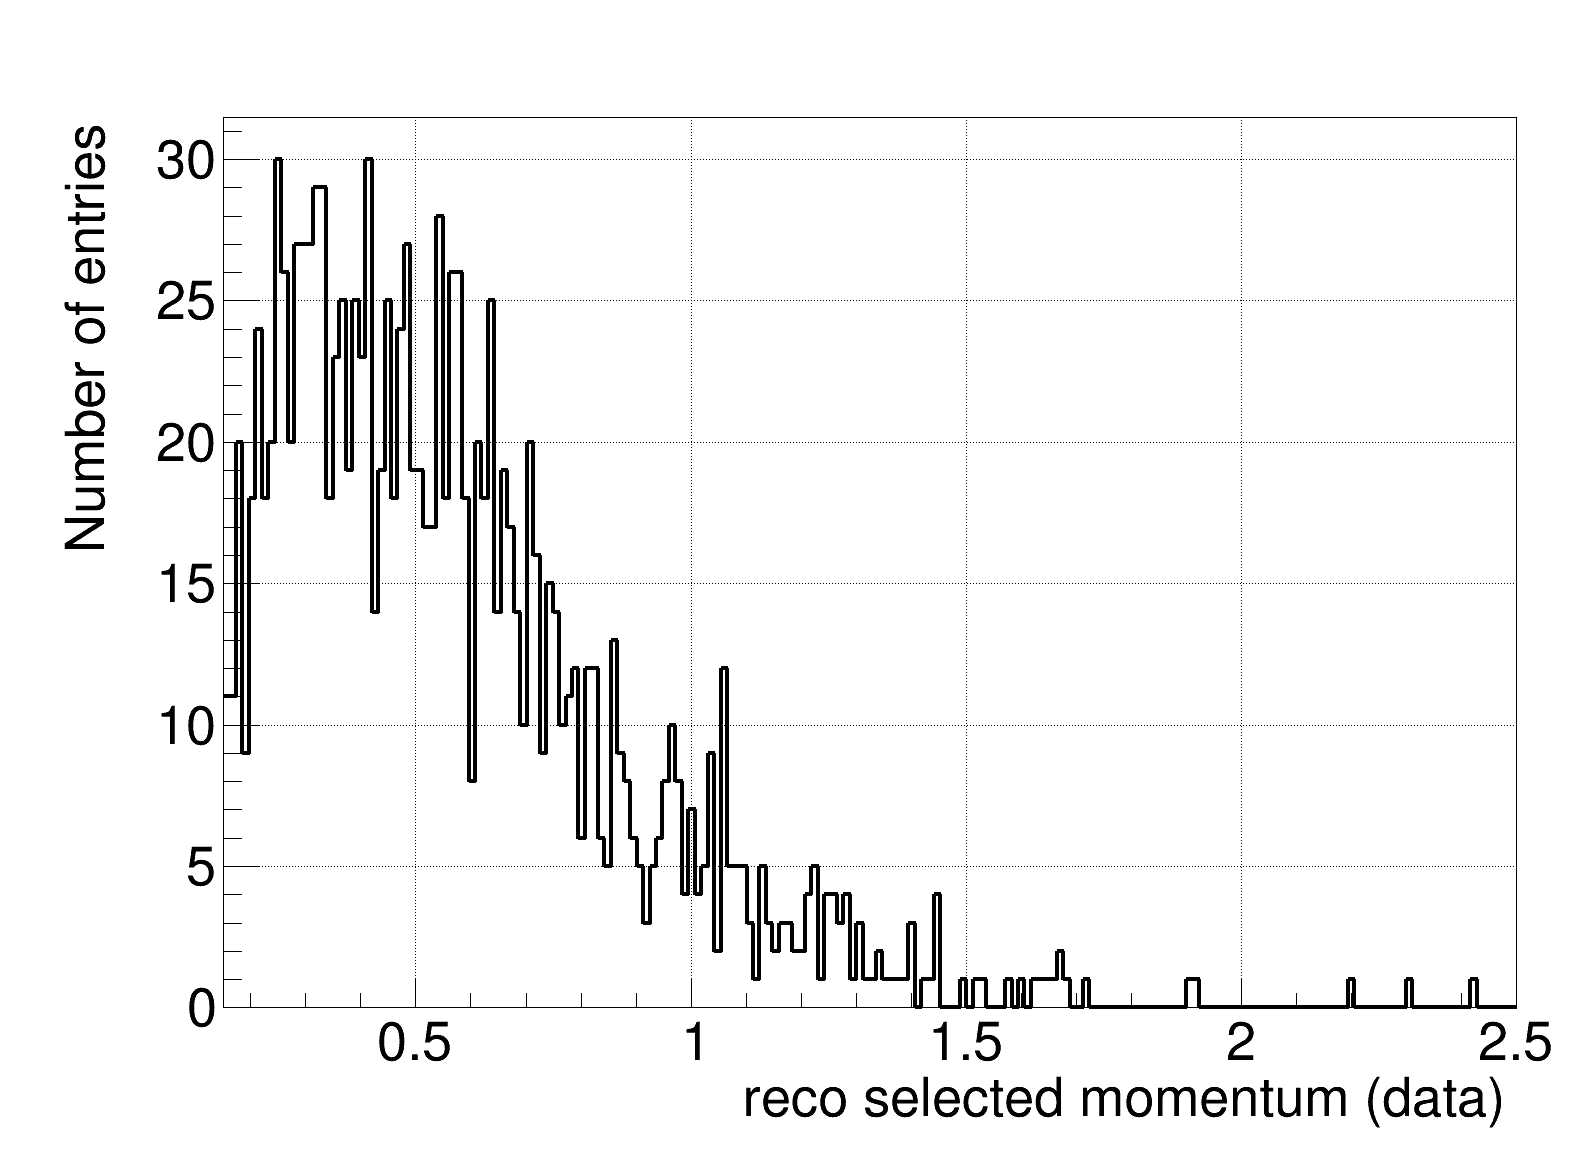

In [23]:
h_data.SetXTitle("reco selected momentum (data)")
h_data.SetYTitle("Number of entries")
h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
h_data.Draw('hist')
c1.Draw()
c1.SaveAs(globale.outputdir_png + 'h_data_rate.png')
c1.SaveAs(globale.outputdir_root + 'h_data_rate.png')
c1.SaveAs(globale.outputdir_pdf + 'h_data_rate.png')


In [24]:
h_test = h_data.Clone()
h_test.Add(h_ext,-1)
h_test.Add(h_dirt,-1)
h_test.Add(h_overlay,-1)

True

Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/png/h_data_bkgsub_rate.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/root/h_data_bkgsub_rate.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/pdf/h_data_bkgsub_rate.png has been created


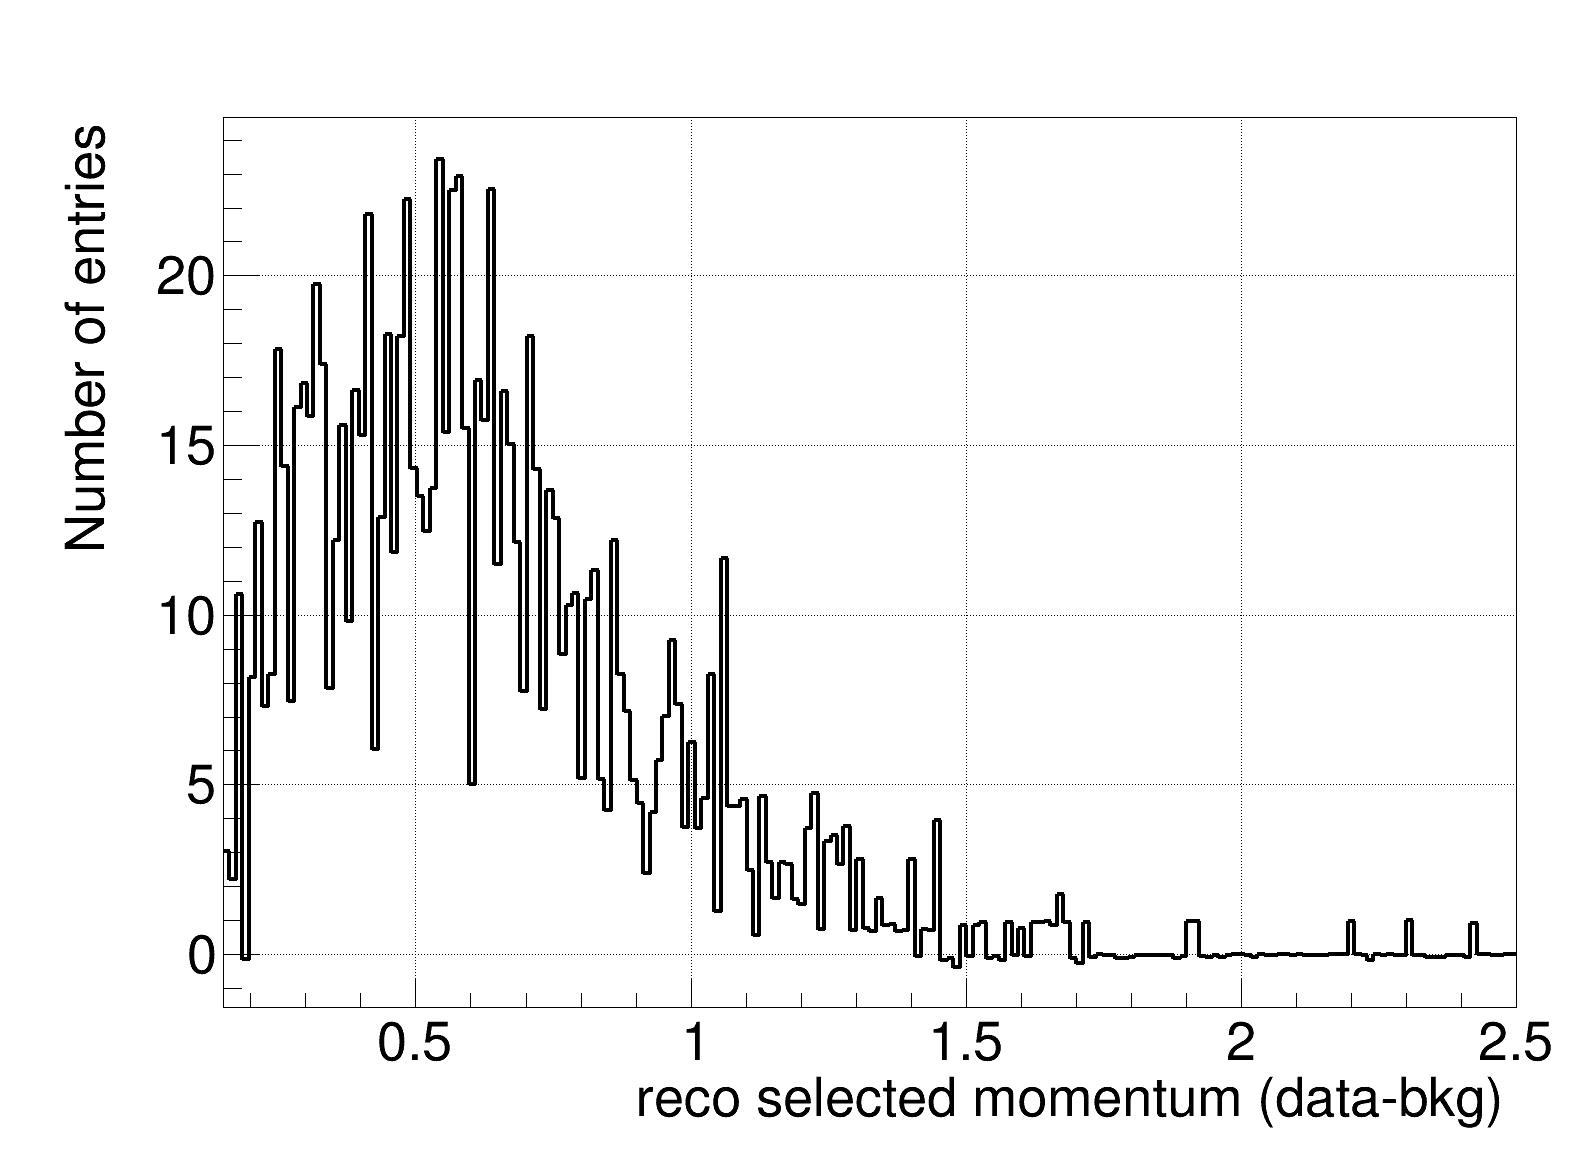

In [25]:
h_test.SetXTitle("reco selected momentum (data-bkg)")
h_test.SetYTitle("Number of entries")
h_test.GetYaxis().SetTitleSize(0.05)
h_test.GetYaxis().SetTitleOffset(0.0)
h_test.GetYaxis().SetLabelSize(0.05)
h_test.GetXaxis().SetTitleSize(0.05)
h_test.GetXaxis().SetLabelSize(0.05)
h_test.GetXaxis().SetTitleOffset(1)
h_test.SetLineColor(ROOT.kBlack)
h_test.SetLineWidth(4)
h_test.Draw('hist')
c1.Draw()
c1.SaveAs(globale.outputdir_png + 'h_data_bkgsub_rate.png')
c1.SaveAs(globale.outputdir_root + 'h_data_bkgsub_rate.png')
c1.SaveAs(globale.outputdir_pdf + 'h_data_bkgsub_rate.png')


In [26]:
f = ROOT.TF1("my_distribution", my_distribution, 0, 2.5, binnum)
f.SetParameters(np.zeros((binnum)))
for i in range (binnum):
    f.SetParLimits(i,0.0, h_true.GetBinContent(i+1)*50000);
result = h_test.Fit(f,'WL')
#result = h_signal.Fit(f,'WL')

print f.GetParameters()[0]

20.5227117065

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =      99.1342
Chi2                      =      18528.3
NDf                       =          194
Edm                       =   1.7933e-06
NCalls                    =          320
p0                        =      20.5227   +/-   14.7267      	 (limited)
p1                        =      255.983   +/-   31.9267      	 (limited)
p2                        =      346.752   +/-   37.3614      	 (limited)
p3                        =      780.671   +/-   49.4017      	 (limited)
p4                        =      347.432   +/-   38.2921      	 (limited)
p5                        =      38.0147   +/-   19.4475      	 (limited)


Warning in <ROOT::Math::Fitter::ApplyWeightCorrection>: Covariance matrix for weighted likelihood is not accurate, the errors may be not reliable
Error in <TMinuitMinimizer::GetHessianMatrix>: Hessian matrix has not been computed - status 1
Error in <ROOT::Math::Fitter::ApplyWeightCorrection>: Error retrieving Hesse on weight2 likelihood - cannot compute errors
Warning in <Fit>: Abnormal termination of minimization.


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/png/result_fit.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/root/result_fit.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/pdf/result_fit.pdf has been created


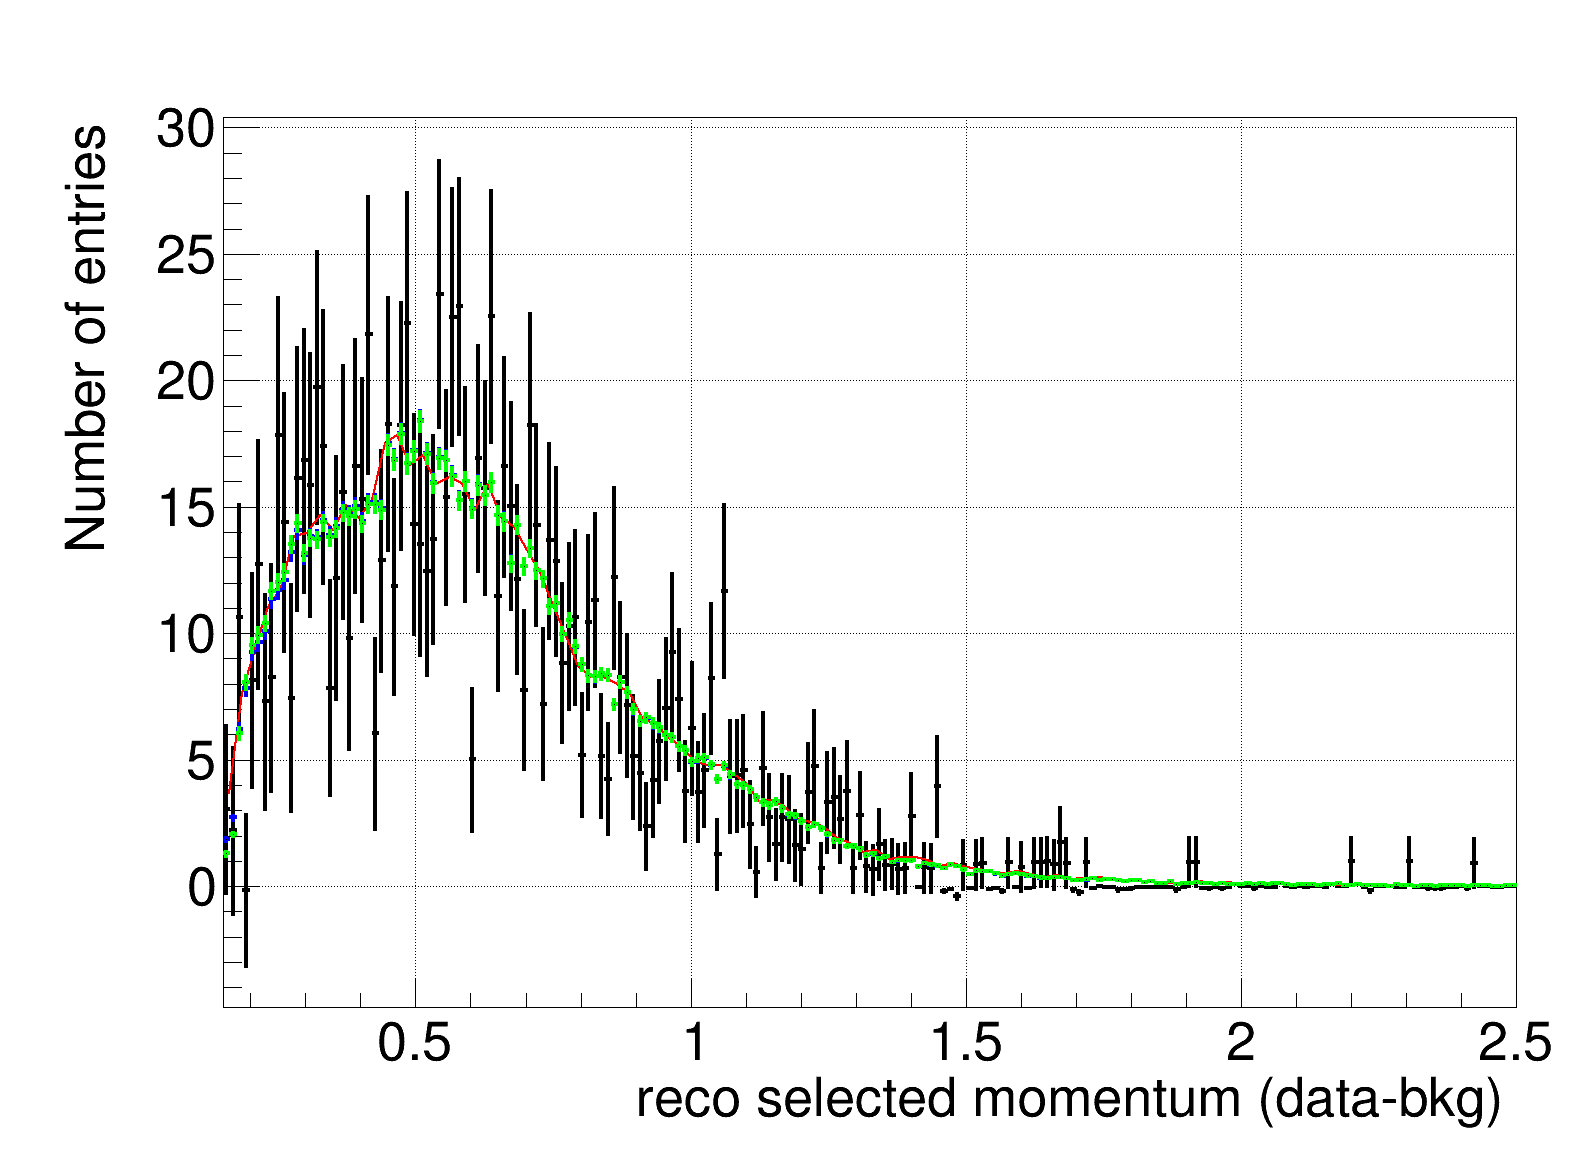

In [27]:
h_test.Draw()
f.Draw('same')
h_test_RooFit = ROOT.TH1F("h_test_RooFit",'h_test_RooFit',binnum2,array('f',mom_bins2))
h_tmp = ROOT.TH1F("h_tmp",'h_tmp',binnum2,array('f',mom_bins2))
h_tmp = h_temp[0].Clone()
h_tmp.Scale(1.02725e+01)
h_test_RooFit.Add(h_tmp)
h_tmp = h_temp[1].Clone()
h_tmp.Scale(2.64695e+02)
h_test_RooFit.Add(h_tmp)
h_tmp = h_temp[2].Clone()
h_tmp.Scale(3.40477e+02)
h_test_RooFit.Add(h_tmp)
h_tmp = h_temp[3].Clone()
h_tmp.Scale(7.86136e+02)
h_test_RooFit.Add(h_tmp)
h_tmp = h_temp[4].Clone()
h_tmp.Scale(3.54204e+02)
h_test_RooFit.Add(h_tmp)
h_tmp = h_temp[5].Clone()
h_tmp.Scale(2.48130e+01)
h_test_RooFit.Add(h_tmp)
h_test_RooFit.SetLineColor(ROOT.kBlue)
h_test_RooFit.SetLineWidth(4)

h_test_RooFit2 = ROOT.TH1F("h_test_RooFit2",'h_test_RooFit2',binnum2,array('f',mom_bins2))
h_tmp = ROOT.TH1F("h_tmp",'h_tmp',binnum2,array('f',mom_bins2))
h_tmp = h_temp[0].Clone()
h_tmp.Scale(2.86682e+00)
h_test_RooFit2.Add(h_tmp)
h_tmp = h_temp[1].Clone()
h_tmp.Scale(2.74228e+02)
h_test_RooFit2.Add(h_tmp)
h_tmp = h_temp[2].Clone()
h_tmp.Scale(3.37087e+02)
h_test_RooFit2.Add(h_tmp)
h_tmp = h_temp[3].Clone()
h_tmp.Scale(7.84845e+02)
h_test_RooFit2.Add(h_tmp)
h_tmp = h_temp[4].Clone()
h_tmp.Scale(3.55081e+02)
h_test_RooFit2.Add(h_tmp)
h_tmp = h_temp[5].Clone()
h_tmp.Scale(2.51272e+01)
h_test_RooFit2.Add(h_tmp)
h_test_RooFit2.SetLineColor(ROOT.kGreen)
h_test_RooFit2.SetLineWidth(4)


#h_test_RooFit.Scale(1/scale[overlay])
h_test_RooFit.Draw('same')
h_test_RooFit2.Draw('same')
c1.Draw()
c1.SaveAs(globale.outputdir_png + 'result_fit.png')
c1.SaveAs(globale.outputdir_root + 'result_fit.root')
c1.SaveAs(globale.outputdir_pdf + 'result_fit.pdf')

In [28]:
h_true_reco = ROOT.TH1F('h_true_reco','h_true_reco',binnum,array('f',mom_bins))
globale.overlay_out.Draw('TrackMomMCS_mom>>h_true',weight_name+'*('+cut+'&& track_end_uncontained)')
h_true_r = ROOT.TH1F('h_true_r','h_true_r',binnum,array('f',mom_bins))
globale.overlay_out.Draw('TrackMomRange_mu>>h_true_r',weight_name+'*('+cut+' && !track_end_uncontained)')
h_true_reco.Add(h_true_r)
h_true_reco.Scale(scale[overlay])
h_true_reco.SetLineWidth(4)
h_true_reco.SetLineColor(ROOT.kRed)

In [29]:
h_true = ROOT.TH1F('h_true','h_true',binnum,array('f',mom_bins))
globale.overlay_out.Draw('MCle_Energy>>h_true',weight_name+'*(numu_true)')
h_true.Scale(scale[overlay])
h_true.SetLineWidth(4)
h_true.SetLineColor(ROOT.kYellow)

Warning in <TFile::Append>: Replacing existing TH1: h_true (Potential memory leak).


0.227908195258 20.5227117065 45.7461433411
0.383176350977 255.982919612 244.451705933
0.480910394201 346.751884911 345.564697266
0.575852100682 780.671297426 552.046936035
0.674830990147 347.431794725 410.678192139
0.689332258597 38.0146770294 127.770111084


Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/png/h_data_bkgsub_rate_true.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/root/h_data_bkgsub_rate_true.png has been created
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/pdf/h_data_bkgsub_rate_true.png has been created


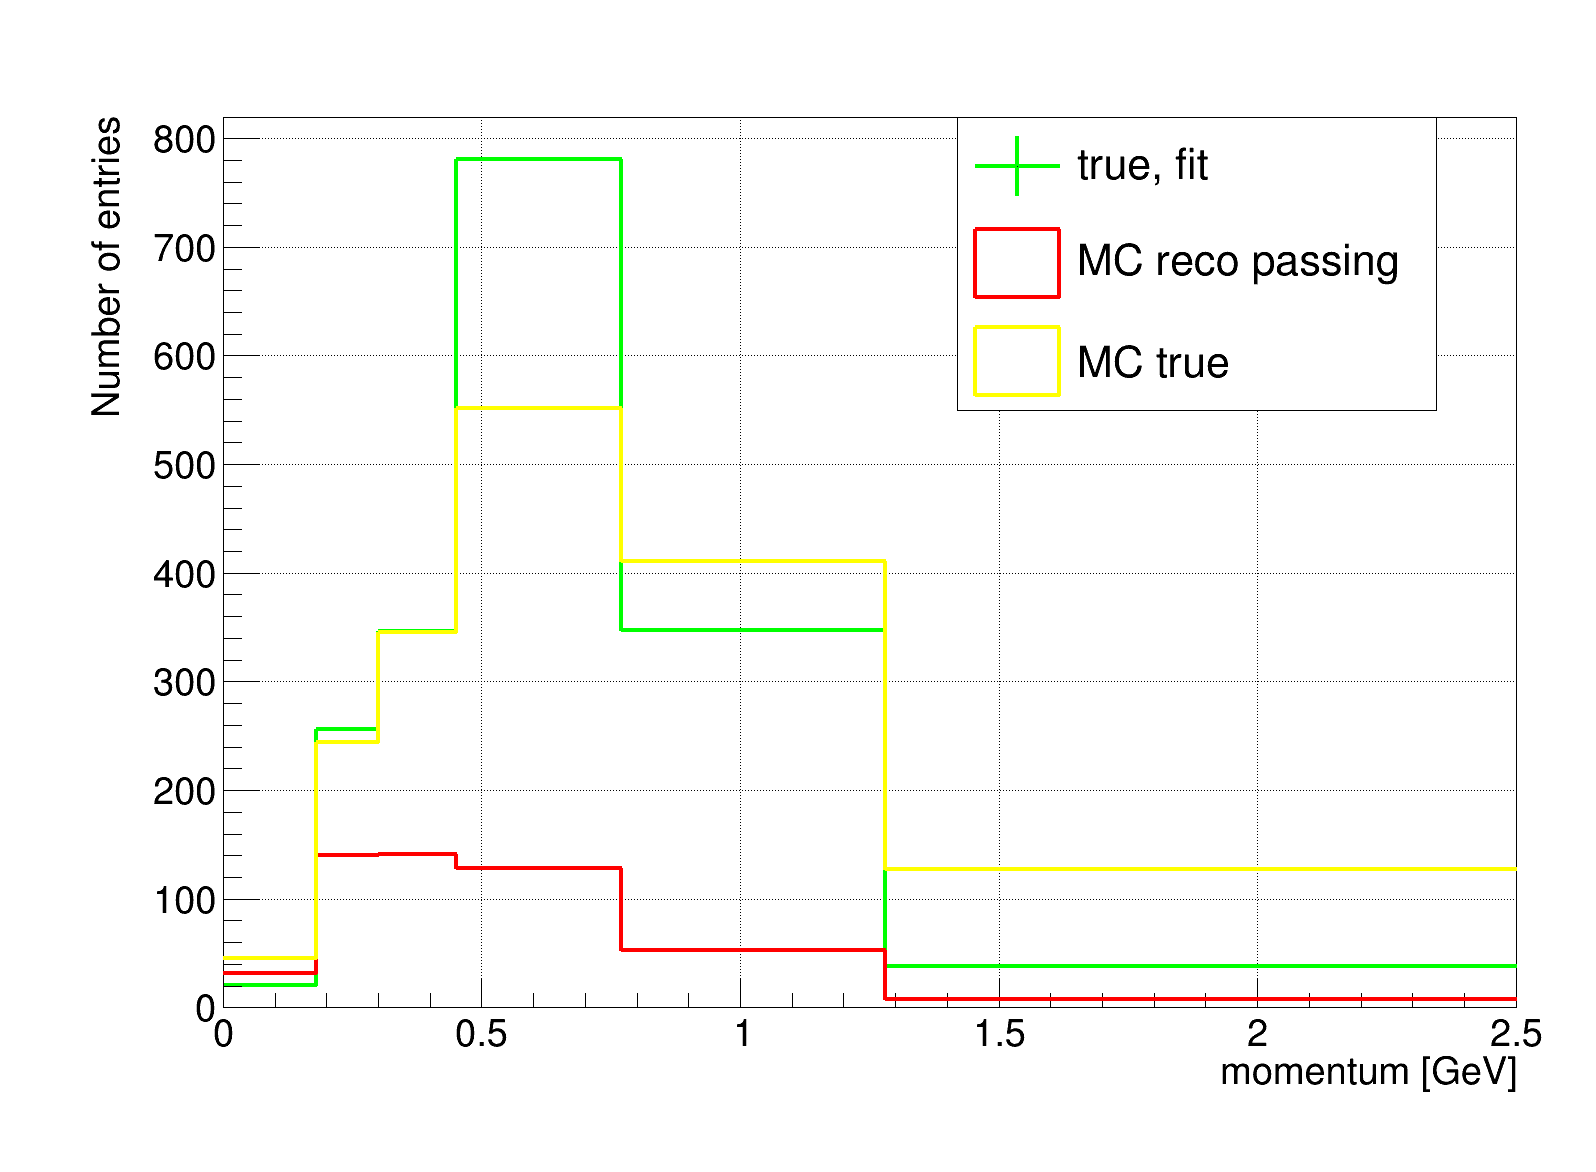

In [30]:
h_true_fit = ROOT.TH1F('h_true_fit','h_true_fit',binnum,array('f',mom_bins))
h_true_fit.SetLineColor(ROOT.kGreen)
h_true_fit.SetLineWidth(4)
for i in range(binnum):
    num_true = h_temp[i].GetSumOfWeights() #Integral(0,binnum)
    fit_scale = f.GetParameters()[i]
    print num_true, fit_scale, h_true.GetBinContent(i+1)
    h_true_fit.SetBinContent(i+1,fit_scale)

h_true_fit.Draw('HIST')

h_true_reco.Draw('HIST same')
h_true.Draw('hist same')

legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
legend.AddEntry(h_true_fit,'true, fit',"lep");
legend.AddEntry(h_true_reco,'MC reco passing',"f");
legend.AddEntry(h_true,'MC true',"f");
legend.Draw()

h_true_fit.SetXTitle("momentum [GeV]")
h_true_fit.SetYTitle("Number of entries")

c1.Draw()
c1.SaveAs(globale.outputdir_png + 'h_data_bkgsub_rate_true.png')
c1.SaveAs(globale.outputdir_root + 'h_data_bkgsub_rate_true.png')
c1.SaveAs(globale.outputdir_pdf + 'h_data_bkgsub_rate_true.png')

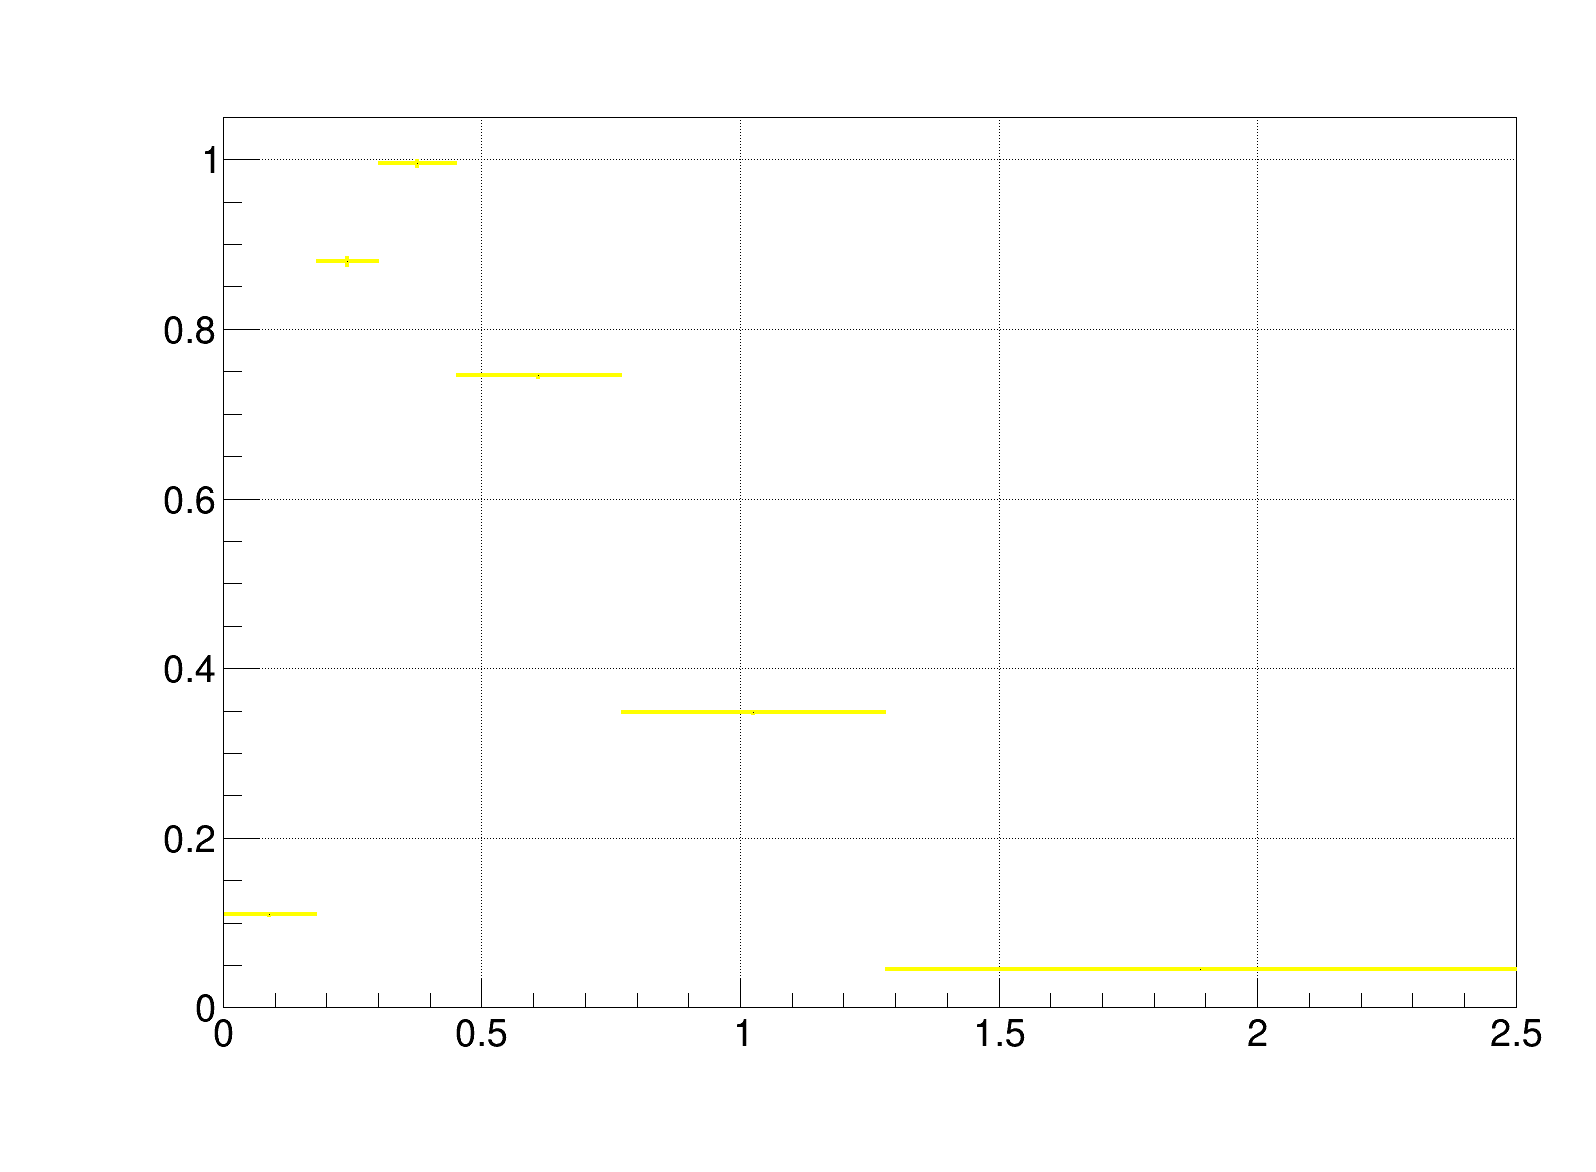

In [31]:
h_true_xsec = h_true.Clone()
h_true_xsec.Scale(1.0/(N_tot*beam_flux*1e-38))
#h_true_xsec.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_xsec.SetBinContent(i,h_true_xsec.GetBinContent(i)/h_true_xsec.GetBinWidth(i))
    h_true_xsec.SetBinError(i,h_true_xsec.GetBinError(i)/h_true_xsec.GetBinWidth(i))

h_true_xsec.Draw()
c1.Draw()

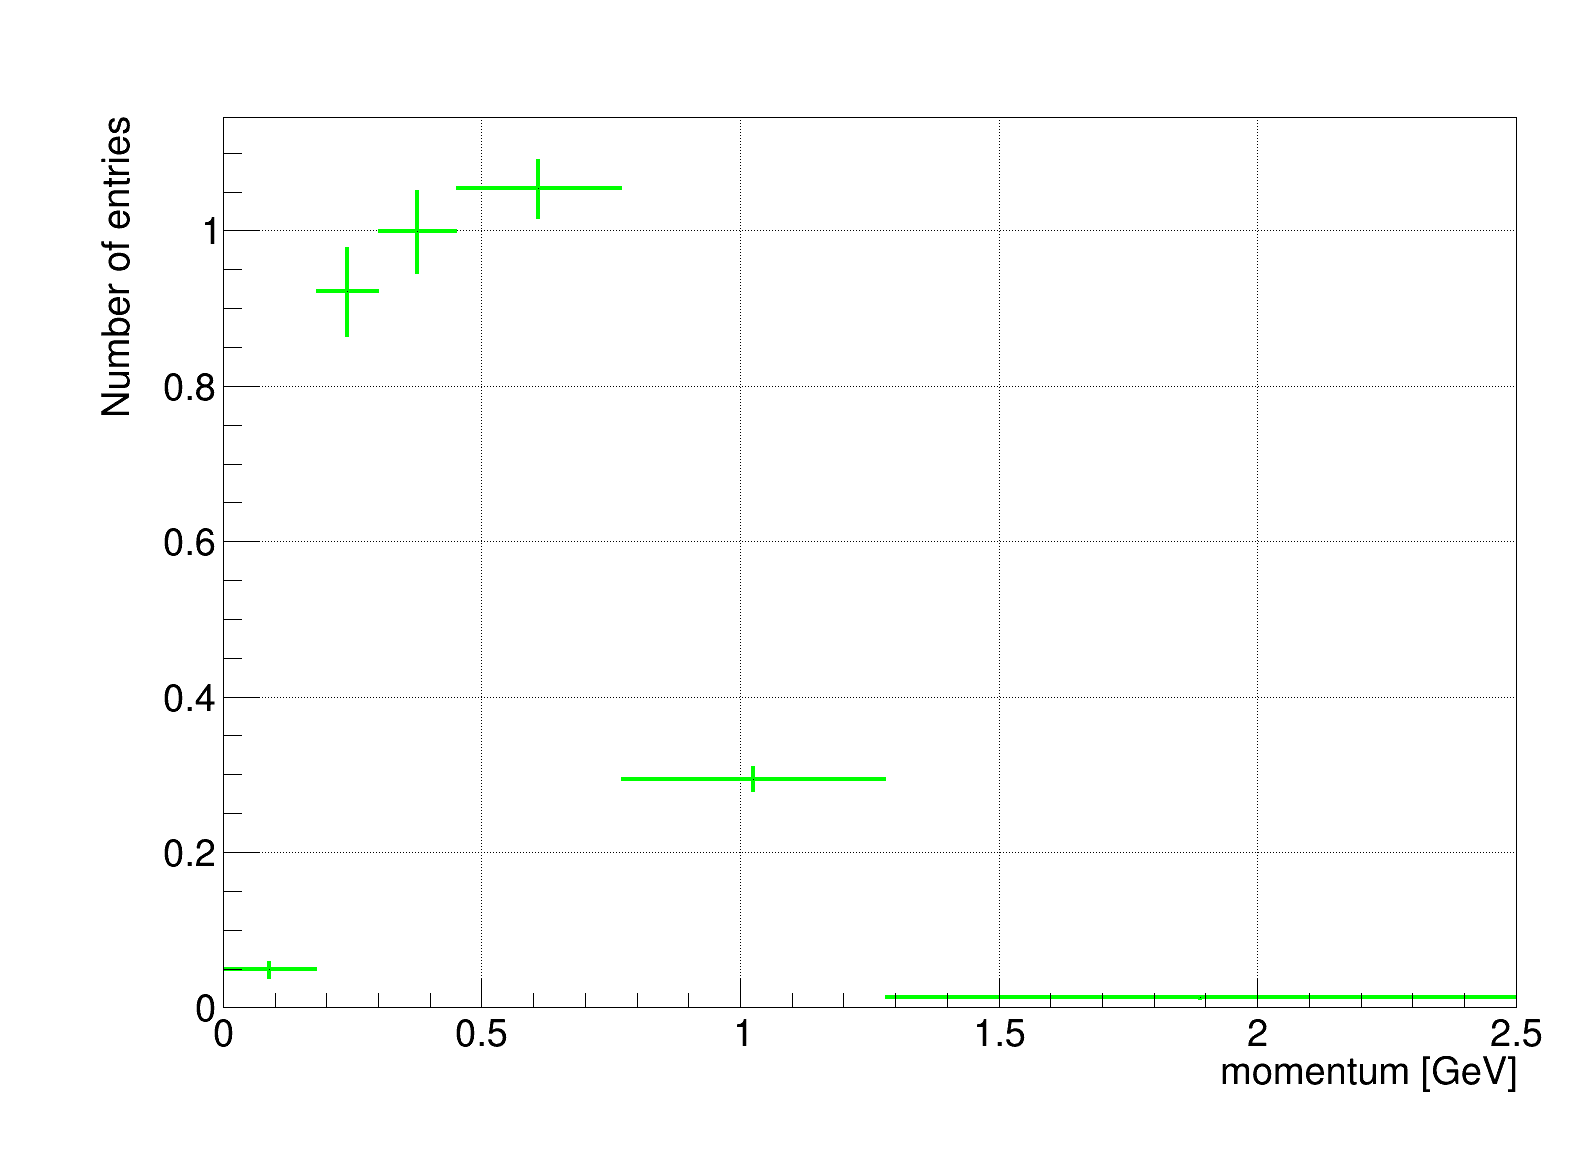

In [32]:
h_true_fit_t = h_true_fit.Clone()
h_true_fit_t.Scale(1.0/(N_tot*beam_flux*1e-38))
#h_true_fit_t.Divide(h_eff_true)
for i in range(1,binnum+1):
    h_true_fit_t.SetBinContent(i,h_true_fit_t.GetBinContent(i)/h_true_fit_t.GetBinWidth(i))
    h_true_fit_t.SetBinError(i,h_true_fit_t.GetBinError(i)/h_true_fit_t.GetBinWidth(i))

h_true_fit_t.Draw()
c1.Draw()

In [35]:
legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
legend.AddEntry(h_true_fit_t,'data',"lep");
legend.AddEntry(h_true_xsec,'MC',"f");
h_true_fit_t.SetYTitle("d\sigma / dp_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_true_fit_t.SetXTitle("p_{\mu} \t [GeV]")
h_true_fit_t.SetLineWidth(3)
h_true_fit_t.SetMaximum(1.6)

h_true_fit_t.GetYaxis().SetTitleSize(0.05)
h_true_fit_t.GetYaxis().SetTitleOffset(0.0)
h_true_fit_t.GetYaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleSize(0.05)
h_true_fit_t.GetXaxis().SetLabelSize(0.05)
h_true_fit_t.GetXaxis().SetTitleOffset(1)
h_true_fit_t.SetLineColor(ROOT.kBlack)
h_true_fit_t.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_true_fit_t.Draw('E1')
h_true_xsec.SetLineColor(2)
h_true_xsec.SetFillColor(0)
h_true_xsec.SetLineWidth(4)
#h_true_t.Draw('hist same')
h_true_xsec.DrawCopy('Hist same')
h_true_xsec.SetFillColor(2)
h_true_xsec.SetFillStyle(3001)
h_true_xsec.Draw('E2 same')
legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()
#c1.Draw()
#c1.SaveAs(globale.outputdir_png + "h_xsec_corr.png")
#c1.SaveAs(globale.outputdir_root + "h_xsec_corr.root")
#c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr.pdf")

h_true_fit_t.Write("h_xsec_data")
h_true_xsec.Write("h_xsec_MC")


419

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/png/h_xsec_corr_ratio.png has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/root/h_xsec_corr_ratio.root has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/xsec_momentum_fit_res_both/pdf/h_xsec_corr_ratio.pdf has been created


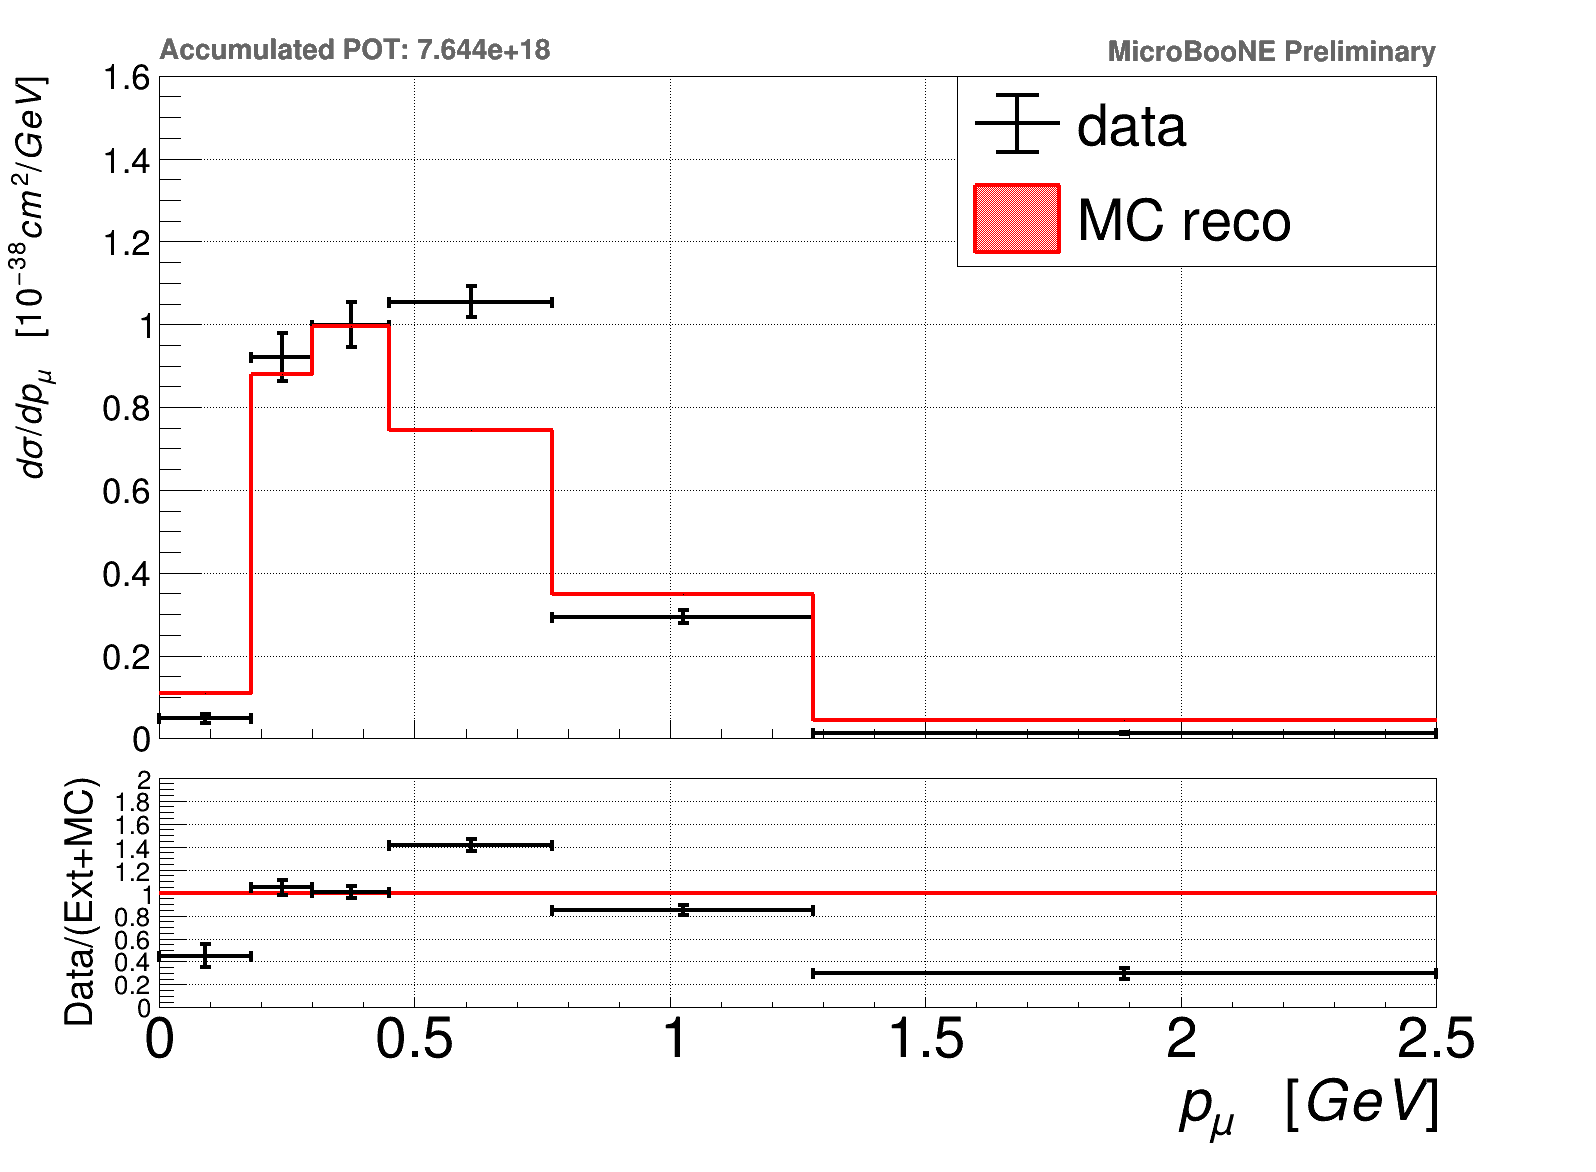

In [36]:
h_data = h_true_fit_t.Clone()
h_overlay_sig = h_true_xsec.Clone()

legend = ROOT.TLegend(0.6,0.65,0.9,0.9)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.1)
c1.SetBottomMargin(0.1)
#c1.SetFillStyle(4000);
# first pad
c1.cd()
pad1 = ROOT.TPad('pad1','pad1',0,0.35,1,1)
pad1.SetGrid(1)
pad1.Draw()
pad1.cd()
pad1.SetBottomMargin(0.03);
pad1.SetTopMargin(0.1)

h_overlay_sig.SetLineColor(2)
legend.AddEntry(h_data,'data',"lep");
legend.AddEntry(h_overlay_sig,'MC reco',"f");

h_data.SetYTitle("d\sigma / dp_{\mu} \t [10^{-38} cm^{2}/GeV]")
h_data.SetXTitle("p_{\mu} \t [GeV]")
h_data.SetLineWidth(3)
h_data.SetMaximum(1.6)

h_data.GetYaxis().SetTitleSize(0.05)
h_data.GetYaxis().SetTitleOffset(0.0)
h_data.GetYaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleSize(0.05)
h_data.GetXaxis().SetLabelSize(0.05)
h_data.GetXaxis().SetTitleOffset(1)
h_data.SetLineColor(ROOT.kBlack)
h_data.SetLineWidth(4)
ROOT.gStyle.SetEndErrorSize(5)
c1.SetRightMargin(0.05)

h_data.GetXaxis().SetLabelOffset(999);
h_data.GetXaxis().SetTitleOffset(999);
h_data.GetXaxis().SetLabelSize(0);
h_data.GetXaxis().SetTitleSize(0);

h_data.Draw('E1')
h_overlay_sig.SetFillColor(0)
h_overlay_sig.SetLineWidth(4)
#h_overlay_sig.Draw('hist same')
h_overlay_sig.DrawCopy('Hist same')
h_overlay_sig.SetFillColor(2)
h_overlay_sig.SetFillStyle(3001)
h_overlay_sig.Draw('E2 same')

legend.Draw()
prelim, pot_tex = draw_adding()
prelim.Draw()
pot_tex.Draw()

c1.cd()
h_data.GetXaxis().SetLabelOffset(0);
h_data.GetXaxis().SetTitleOffset(0);

pad2 = ROOT.TPad('pad2','pad2',0,0,1,0.35)
pad2.SetGrid(1)
pad2.SetTopMargin(0.04)
pad2.SetBottomMargin(0.4)
pad2.Draw()
pad2.cd()

h_overlay_sig_ratio = h_overlay_sig.Clone()
h_overlay_sig_ratio.Divide(h_overlay_sig)
h_overlay_data_ratio = h_data.Clone()
h_overlay_data_ratio.Divide(h_overlay_sig)

h_overlay_data_ratio.SetMinimum(0.0)
h_overlay_data_ratio.SetMaximum(2.0)
h_overlay_sig_ratio.SetFillColor(0)
h_overlay_data_ratio.SetYTitle('Data/(Ext+MC)')
h_overlay_data_ratio.GetYaxis().SetTitleSize(0.1)
h_overlay_data_ratio.GetYaxis().SetTitleOffset(0.3)
h_overlay_data_ratio.GetYaxis().SetLabelSize(0.07)
h_overlay_data_ratio.GetXaxis().SetTitleSize(0.15)
h_overlay_data_ratio.GetXaxis().SetLabelSize(0.15)
h_overlay_data_ratio.GetXaxis().SetTitleOffset(1)

h_overlay_data_ratio.Draw('E1')
h_overlay_sig_ratio.Draw('same hist')
h_overlay_data_ratio.Draw('E1 same')


c1.Draw()
c1.SaveAs(globale.outputdir_png + "h_xsec_corr_ratio.png")
c1.SaveAs(globale.outputdir_root + "h_xsec_corr_ratio.root")
c1.SaveAs(globale.outputdir_pdf + "h_xsec_corr_ratio.pdf")

#h_data.Write("h_xsec_data")
#h_overlay_sig.Write("h_xsec_MC")

In [34]:
# close the root file with all the histos
#RootFile.Close()